<a href="https://colab.research.google.com/github/it21303302b/DL_LAB_08/blob/main/DL_q3_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 3: Introduction to Deep Q-Learning (DQN)**

## Objective: Transition from traditional Q-Learning to Deep Q-Learning, building on the foundational knowledge gained in the previous tasks.

Tasks:
1. Extend your implementation from Question 1 to develop a Deep Q-Learning (DQN)
model. Use a neural network to approximate the Q-values instead of using a lookup
table.
2. Implement an epsilon-greedy strategy for action selection in the DQN, testing different
epsilon values (e.g., 0.1, 0.5, 0.9) to analyze the balance between exploration and
exploitation.
3. Compare the convergence and performance of the DQN model at different epsilon
values and plot the results.
4. Add screenshots, the plots, and a brief discussion of your observations to the Word
document.

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [2]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Epsilon-greedy action selection
def epsilon_greedy_action(network, state, epsilon, action_size):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)  # Random action
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = network(state)
            return q_values.argmax().item()  # Best action

In [5]:
# Training Loop
def train_dqn(env, episodes=500, gamma=0.99, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995,
              batch_size=64, buffer_size=10000, learning_rate=0.001, target_update_frequency=10):

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create the DQN and target network
    dqn = DQN(state_size, action_size)
    target_dqn = DQN(state_size, action_size)
    target_dqn.load_state_dict(dqn.state_dict())  # Initialize target network with same weights
    target_dqn.eval()

    # Optimizer and loss function
    optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Replay buffer
    replay_buffer = ReplayBuffer(buffer_size)

    epsilon = epsilon_start
    all_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        done = False
        while not done:
            action = epsilon_greedy_action(dqn, state, epsilon, action_size)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store experience in replay buffer
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state

            # Only train if replay buffer has enough samples
            if len(replay_buffer) >= batch_size:
                experiences = replay_buffer.sample(batch_size)
                train_step(dqn, target_dqn, optimizer, loss_fn, experiences, gamma)

            if done:
                break

        all_rewards.append(total_reward)

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon_decay * epsilon)

        # Update target network periodically
        if episode % target_update_frequency == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return all_rewards

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-6-fcbfdfec1076>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray

Episode 10/500, Total Reward: 14.0, Epsilon: 0.951
Episode 20/500, Total Reward: 14.0, Epsilon: 0.905
Episode 30/500, Total Reward: 16.0, Epsilon: 0.860
Episode 40/500, Total Reward: 20.0, Epsilon: 0.818
Episode 50/500, Total Reward: 33.0, Epsilon: 0.778
Episode 60/500, Total Reward: 25.0, Epsilon: 0.740
Episode 70/500, Total Reward: 15.0, Epsilon: 0.704
Episode 80/500, Total Reward: 42.0, Epsilon: 0.670
Episode 90/500, Total Reward: 15.0, Epsilon: 0.637
Episode 100/500, Total Reward: 36.0, Epsilon: 0.606
Episode 110/500, Total Reward: 44.0, Epsilon: 0.576
Episode 120/500, Total Reward: 83.0, Epsilon: 0.548
Episode 130/500, Total Reward: 95.0, Epsilon: 0.521
Episode 140/500, Total Reward: 104.0, Epsilon: 0.496
Episode 150/500, Total Reward: 107.0, Epsilon: 0.471
Episode 160/500, Total Reward: 59.0, Epsilon: 0.448
Episode 170/500, Total Reward: 82.0, Epsilon: 0.427
Episode 180/500, Total Reward: 169.0, Epsilon: 0.406
Episode 190/500, Total Reward: 173.0, Epsilon: 0.386
Episode 200/500, 

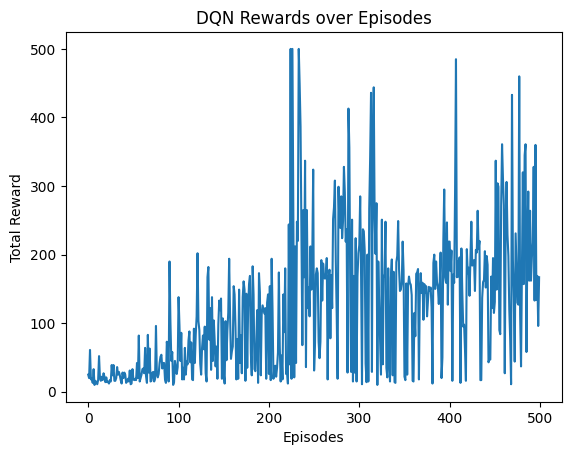

In [6]:
# Training step
def train_step(dqn, target_dqn, optimizer, loss_fn, experiences, gamma):
    states, actions, rewards, next_states, dones = zip(*experiences)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    # Current Q-values
    q_values = dqn(states).gather(1, actions)

    # Target Q-values using target network
    with torch.no_grad():
        max_next_q_values = target_dqn(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

    # Compute loss and optimize
    loss = loss_fn(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main function to run the DQN
if __name__ == "__main__":
    env = gym.make('CartPole-v1')

    episodes = 500
    rewards = train_dqn(env, episodes=episodes)

    # Plotting reward progression (optional, you can use matplotlib)
    import matplotlib.pyplot as plt
    plt.plot(rewards)
    plt.title('DQN Rewards over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.show()


IT21303302 - Weerakoon W.M.B.B